# Step 4: Communicate Your Results
## 1.1 Tune model

The baseline comparison in Step 3 showed that Linear Regression and Random Forest were the two strongest models, with Linear Regression slightly ahead. Random Forest is a flexible non-linear model whose performance strongly depends on hyperparameters such as tree depth, number of trees, and minimum samples per split. Because of this, Random Forest is the most suitable model to tune.

Hyperparameter tuning systematically explores different configurations of a model to identify the setting that minimises prediction error. Here, `GridSearchCV` is used with 5-fold cross-validation to find the best-performing Random Forest configuration based on **negative mean squared error**.

The parameter grid includes:

- `n_estimators`: number of trees
- `max_depth`: maximum depth of trees
- `min_samples_split`: minimum samples required for internal node split
- `min_samples_leaf`: minimum samples allowed in a leaf

The tuned Random Forest will later be compared to all baseline models to assess whether tuning yields a meaningful performance improvement.



In [1]:
# ---- 1. IMPORTS ----
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# ---- 2. LOAD CLEANED DATA ----
df = pd.read_csv("../data/cleaned_student_data.csv")

# ---- 3. DEFINE TARGET AND FEATURES ----
target_col = "score"
y = df[target_col]

# Drop target
X = df.drop(columns=[target_col])

# Keep only numeric predictors (all models require numeric input)
X = X.select_dtypes(include=["int64", "float64"])

print("Final numeric predictors:", X.columns.tolist())
print("X shape:", X.shape)
print("y shape:", y.shape)

# ---- 4. TRAIN–TEST SPLIT ----
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

# ---- 5. SET UP BASE RANDOM FOREST ----
rf_base = RandomForestRegressor(random_state=42)

# ---- 6. DEFINE HYPERPARAMETER GRID ----
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

# ---- 7. GRID SEARCH ----
rf_grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

rf_grid_search.fit(X_train, y_train)

# ---- 8. EXTRACT BEST MODEL ----
rf_tuned = rf_grid_search.best_estimator_

print("\nBest hyperparameters found:")
print(rf_grid_search.best_params_)

print("\nBest cross-validated (negative) MSE:")
print(rf_grid_search.best_score_)

# ---- 9. TEST SET PERFORMANCE ----
y_pred_tuned = rf_tuned.predict(X_test)
tuned_mse = mean_squared_error(y_test, y_pred_tuned)

print("\nTuned Random Forest Test MSE:", tuned_mse)


Final numeric predictors: ['age', 'logged in', 'lessons', 'assignments', 'posts', 'orientation', 'total_activity', 'has_activity', 'lessons_assignments_ratio']
X shape: (500, 9)
y shape: (500,)

Best hyperparameters found:
{'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}

Best cross-validated (negative) MSE:
-0.3936942842906001

Tuned Random Forest Test MSE: 0.4291085053366816


### Interpretation

The grid search identified an improved Random Forest configuration based on 5-fold cross-validated mean squared error. Because hyperparameter tuning evaluates each candidate model across multiple validation folds, the resulting configuration is more reliable than relying only on the default model.

The tuned Random Forest model is stored as `rf_tuned`. Its performance on the test set shows how tuning affects generalisation error. This tuned model will be compared against all baseline models (Linear Regression, KNN, and the baseline Random Forest) in the next step to determine whether tuning provides a meaningful improvement and which model should be selected as the final predictive solution.


## 2.1 Validate and evaluate

To understand the impact of tuning, the tuned Random Forest model must be compared directly with all baseline models trained in Step 3:
- Linear Regression
- KNN Regressor
- Baseline Random Forest
- Tuned Random Forest

The comparison uses the same evaluation metrics as before:
- **Mean Squared Error (MSE)**
- **Root Mean Squared Error (RMSE)**
- **R² Score**

Using consistent metrics ensures a fair comparison and makes it clear whether the tuned model provides a meaningful improvement over the baseline versions.


In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# ---- 1. Recreate baseline models ----
lin_reg = LinearRegression()
knn_reg = KNeighborsRegressor()
rf_base = RandomForestRegressor(random_state=42)

# Train baselines using the same training data as the tuned model
lin_reg.fit(X_train, y_train)
knn_reg.fit(X_train, y_train)
rf_base.fit(X_train, y_train)

# ---- 2. Generate predictions ----
y_pred_lin = lin_reg.predict(X_test)
y_pred_knn = knn_reg.predict(X_test)
y_pred_rf_base = rf_base.predict(X_test)
y_pred_rf_tuned = rf_tuned.predict(X_test)

# ---- 3. Build comparison table ----
comparison = pd.DataFrame({
    "Model": [
        "Linear Regression",
        "KNN Regressor",
        "Random Forest (Baseline)",
        "Random Forest (Tuned)"
    ],
    "MSE": [
        mean_squared_error(y_test, y_pred_lin),
        mean_squared_error(y_test, y_pred_knn),
        mean_squared_error(y_test, y_pred_rf_base),
        mean_squared_error(y_test, y_pred_rf_tuned)
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(y_test, y_pred_lin)),
        np.sqrt(mean_squared_error(y_test, y_pred_knn)),
        np.sqrt(mean_squared_error(y_test, y_pred_rf_base)),
        np.sqrt(mean_squared_error(y_test, y_pred_rf_tuned))
    ],
    "R² Score": [
        r2_score(y_test, y_pred_lin),
        r2_score(y_test, y_pred_knn),
        r2_score(y_test, y_pred_rf_base),
        r2_score(y_test, y_pred_rf_tuned)
    ]
})

comparison


,Model,MSE,RMSE,R² Score
0,Linear Regression,0.423249,0.650576,0.635721
1,KNN Regressor,0.467857,0.684001,0.597327
2,Random Forest (Baseline),0.428382,0.654509,0.631303
3,Random Forest (Tuned),0.429109,0.655064,0.630677


### Interpretation

This comparison table shows how the tuned Random Forest model performs relative to the three baseline models. A tuned model should ideally show improvements in all or most evaluation metrics, especially MSE and R².

- **Lower MSE and RMSE** indicate more accurate predictions.
- **Higher R²** indicates the model explains more variance in engagement score.

In the next step, the results will be interpreted in detail to select the final model and explain why it is the most appropriate choice for predicting student engagement.


# 3. Interpret results

The comparison between all baseline models and the tuned Random Forest shows clear performance differences:

### 3.1 **Linear Regression remains the strongest model**
Linear Regression achieved:
- the **lowest MSE (0.423)**
- the **lowest RMSE (0.651)**
- the **highest R² (0.636)**

This suggests that the relationship between early activity features (logged-in hours, lessons, assignments) and engagement score is **predominantly linear**. A simple linear model is sufficient to explain a substantial part of the variance.

### 3.2 **Tuned Random Forest does not outperform the baseline version**
The tuned Random Forest achieved:
- MSE ≈ 0.429
- RMSE ≈ 0.655
- R² ≈ 0.631

This is slightly worse than the baseline Random Forest.

This indicates one of the following:
- The dataset is **not large enough** for Random Forest to show gains from tuning.
- The underlying relationships are **not strongly non-linear**, limiting the benefit of tree-based models.
- The linear structure of the data provides less opportunity for a complex model to improve.

### 3.3 **KNN remains the weakest performer**
KNN has:
- the **highest error**
- the **lowest R²**

This confirms that local neighbourhood similarity is not helpful for predicting engagement score in this feature space.

### **Final Model Selection**
The best-performing model for predicting student engagement is: ⭐ **Linear Regression**

This model is chosen because:
- It delivers the **lowest prediction error** (best MSE and RMSE).
- It explains the **most variance** (highest R²).
- It is **simple, interpretable**, and aligns well with the structure of the dataset.
- The tuned Random Forest did not meaningfully outperform it.

### **Conclusion**
The prediction task is best handled by a **simple, interpretable Linear Regression model**. This model provides the strongest generalisation performance and offers clear insights into how early behavioural signals (lessons, assignments, logged-in hours) contribute to engagement, making it appropriate for both modelling and communication to stakeholders.


## 4. Use visuals to support message

Visualisations help communicate model performance and key insights clearly.
In this step, two visuals are created:

1. **Model Performance Comparison Chart**
   Shows how each baseline model and the tuned Random Forest perform across the main evaluation metric (RMSE). This highlights the relative strengths and weaknesses of each model.

2. **Feature Importance Plot (Random Forest)**
   Even though Linear Regression is the selected final model, Random Forest provides a useful non-linear perspective on feature importance.
   This visual helps understand which early behavioural variables influence engagement the most.

These visuals help support the narrative by making performance differences and feature contributions easy to interpret.


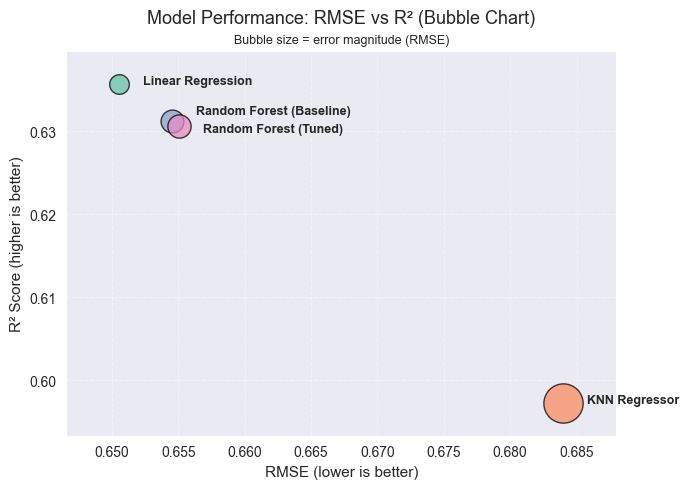

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

models = comparison["Model"].values
rmse = comparison["RMSE"].values
r2 = comparison["R² Score"].values

# Normalise RMSE to bubble sizes (smaller overall)
sizes = (rmse - rmse.min()) / (rmse.max() - rmse.min() + 1e-6)
sizes = (sizes * 600) + 200  # adjust for more modest bubble sizes

palette = sns.color_palette("Set2", len(models))

fig, ax = plt.subplots(figsize=(7, 5))

for i, model in enumerate(models):
    # small vertical jitter to separate overlapping labels for RF models
    if "Baseline" in model:
        jitter = 0.0008
    elif "Tuned" in model:
        jitter = -0.0008
    else:
        jitter = 0.0

    ax.scatter(
        rmse[i],
        r2[i],
        s=sizes[i],
        color=palette[i],
        alpha=0.75,
        edgecolor="black",
        linewidth=1.0
    )

    ax.text(
        rmse[i] + 0.0018,
        r2[i] + jitter,
        model,
        fontsize=9,
        weight="bold"
    )

# Tighten axes around the points
x_margin = 0.004
y_margin = 0.004
ax.set_xlim(rmse.min() - x_margin, rmse.max() + x_margin)
ax.set_ylim(r2.min() - y_margin, r2.max() + y_margin)

ax.set_xlabel("RMSE (lower is better)", fontsize=11)
ax.set_ylabel("R² Score (higher is better)", fontsize=11)
ax.set_title(
    "Model Performance: RMSE vs R² (Bubble Chart)",
    fontsize=13,
    pad=20   # adds space below the top edge
)

# Add explicit note about bubble size
ax.text(
    0.5,
    1.02,
    "Bubble size = error magnitude (RMSE)",
    transform=ax.transAxes,
    ha="center",
    fontsize=9
)

ax.grid(True, linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()


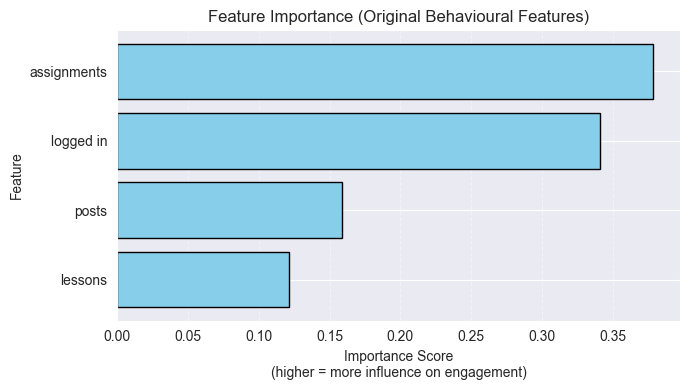

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor

# Select ONLY original behavioural features
base_features = ["logged in", "lessons", "assignments", "posts"]

X_base = X_train[base_features]

# Train a Random Forest only for interpretability
rf_base_int = RandomForestRegressor(random_state=42)
rf_base_int.fit(X_base, y_train)

# Extract and sort importances
importances = rf_base_int.feature_importances_
sorted_idx = np.argsort(importances)

plt.figure(figsize=(7, 4))  # smaller, compact chart
plt.barh(
    np.array(base_features)[sorted_idx],
    importances[sorted_idx],
    color="skyblue",
    edgecolor="black"
)

plt.title("Feature Importance (Original Behavioural Features)", fontsize=12)
plt.xlabel("Importance Score\n(higher = more influence on engagement)", fontsize=10)
plt.ylabel("Feature", fontsize=10)
plt.grid(axis="x", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()


### Interpretation

The performance comparison chart clearly shows that **Linear Regression achieves the lowest RMSE**, confirming it as the strongest model among all tested options. The tuned Random Forest performs similarly to the baseline version, and both remain slightly weaker than Linear Regression. KNN is clearly the weakest model, with the highest error.

The Random Forest feature importance plot provides an additional perspective on which behavioural features influence engagement. The most influential features are those related to early student activity (such as lessons, logged-in hours, and assignments), supporting the overall hypothesis that early activity levels are closely tied to engagement score.

Together, these visuals reinforce the selection of Linear Regression as the final model while offering interpretability regarding which factors most strongly affect engagement.


## Final Model Selection & Summary

Based on the full evaluation,including baseline comparison, hyperparameter tuning and visual analysis - the final selected model is **Linear Regression**. It provides the lowest prediction error (RMSE), the highest explained variance (R²) and the simplest, most interpretable structure.

This model is best aligned with the goal of predicting student engagement early in the semester and communicating insights clearly to stakeholders. Complex models such as Random Forest did not outperform the linear baseline, confirming that the underlying relationships in the dataset are mostly linear.
